In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#https://colab.research.google.com/drive/15Z0jKqyi9uYpXkKUdn3qI5rMDmHR37Xy?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path to the dataset folder in Google Drive
data_path = '/content/drive/MyDrive/Face/crop_face'

# List files in the dataset folder /content/drive/MyDrive/extracted_files/
os.listdir(data_path)


['Person_1',
 'Person_12',
 'Person_9',
 'Person_10',
 'Person_11',
 'Person_13',
 'Person_14',
 'Person_15',
 'Person_16',
 'Person_17',
 'Person_18',
 'Person_19',
 'Person_2',
 'Person_20',
 'Person_21',
 'Person_22',
 'Person_23',
 'Person_24',
 'Person_25',
 'Person_26',
 'Person_27',
 'Person_28',
 'Person_29',
 'Person_3',
 'Person_30',
 'Person_4',
 'Person_5',
 'Person_6',
 'Person_7',
 'Person_8']

In [ ]:
# Define constants
#data_path = '/content/drive/MyDrive/unzipped_dataset/filter40'
input_shape = (224, 224, 3)  # Resize images to 299x299 for InceptionV3
photo_size = 224

In [ ]:
# Setup ImageDataGenerator with rescaling and data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    validation_split=0.2  # Split data into training (80%) and validation (20%)
)


In [ ]:
# Load and prepare training data
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)


Found 1920 images belonging to 30 classes.


In [ ]:
# Load and prepare validation data
validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 480 images belonging to 30 classes.


In [ ]:
# Create the VGG16 model
def create_vgg_model():
    # Load VGG16 model without the top classifier layers
    base_model = VGG16(include_top=False, input_shape=(photo_size, photo_size, 3))

    # Freeze all layers except specific layers (example: layers 1-3 and 15-18)
    for layer_idx in range(len(base_model.layers)):
        if layer_idx not in [1, 2, 3, 15, 16, 17, 18]:
            base_model.layers[layer_idx].trainable = False

    # Add new classifier layers
    flat1 = Flatten()(base_model.output)
    dense1 = Dense(4096, activation='relu')(flat1)
    drop1 = Dropout(0.5)(dense1)
    dense2 = Dense(4096, activation='relu')(drop1)
    drop2 = Dropout(0.5)(dense2)
    dense3 = Dense(2048, activation='relu')(drop2)  # Additional layer
    drop3 = Dropout(0.5)(dense3)  # Additional layer
    output = Dense(train_generator.num_classes, activation='softmax')(drop3)

    # Define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    return model


In [ ]:
# Instantiate and compile the VGG19 model
vgg_model = create_vgg_model()
vgg_model.summary()
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Train the model and capture the history
history = vgg_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


Epoch 1/20
60/60 [==============================] - 628s 10s/step - loss: 3.3729 - accuracy: 0.0953 - val_loss: 2.4700 - val_accuracy: 0.3979
Epoch 2/20
60/60 [==============================] - 25s 421ms/step - loss: 1.5914 - accuracy: 0.5432 - val_loss: 0.6611 - val_accuracy: 0.8188
Epoch 3/20
60/60 [==============================] - 23s 387ms/step - loss: 0.6074 - accuracy: 0.8141 - val_loss: 0.3888 - val_accuracy: 0.8792
Epoch 4/20
60/60 [==============================] - 24s 395ms/step - loss: 0.2877 - accuracy: 0.9078 - val_loss: 0.3239 - val_accuracy: 0.9312
Epoch 5/20
60/60 [==============================] - 27s 442ms/step - loss: 0.1357 - accuracy: 0.9589 - val_loss: 0.3045 - val_accuracy: 0.9354
Epoch 6/20
60/60 [==============================] - 26s 438ms/step - loss: 0.1005 - accuracy: 0.9667 - val_loss: 0.3667 - val_accuracy: 0.9271
Epoch 7/20
60/60 [==============================] - 24s 401ms/step - loss: 0.0502 - accuracy: 0.9859 - val_loss: 0.1859 - val_accuracy: 0.9583


In [ ]:
#Save the mode

model_save_path = '/content/drive/MyDrive/vgg16_face.h5'

# Save the model
vgg_model.save(model_save_path)

print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


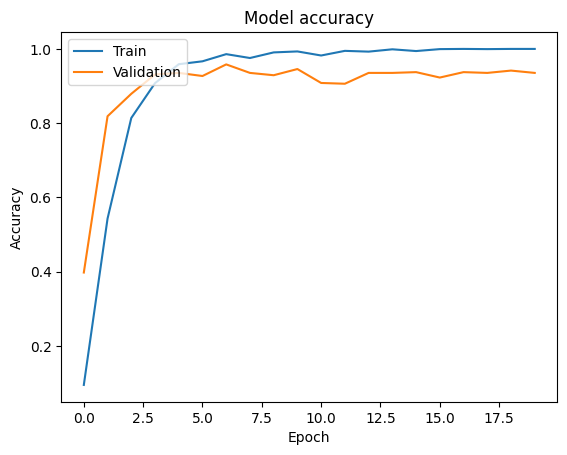

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


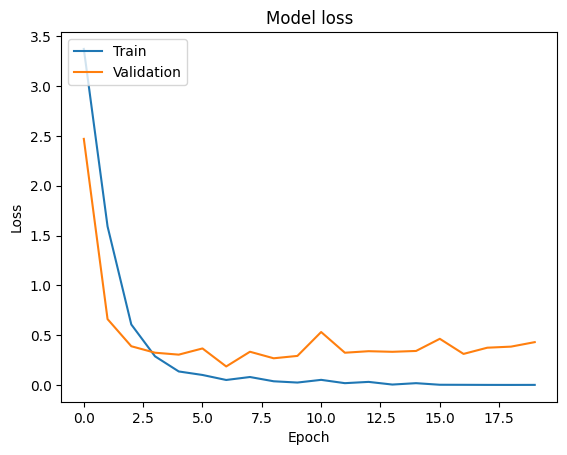

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:

validation_generator.reset()
predictions = vgg_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)


15/16 [===========================>..] - ETA: 0s

16/16 [==============================] - 4s 209ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [ ]:
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())


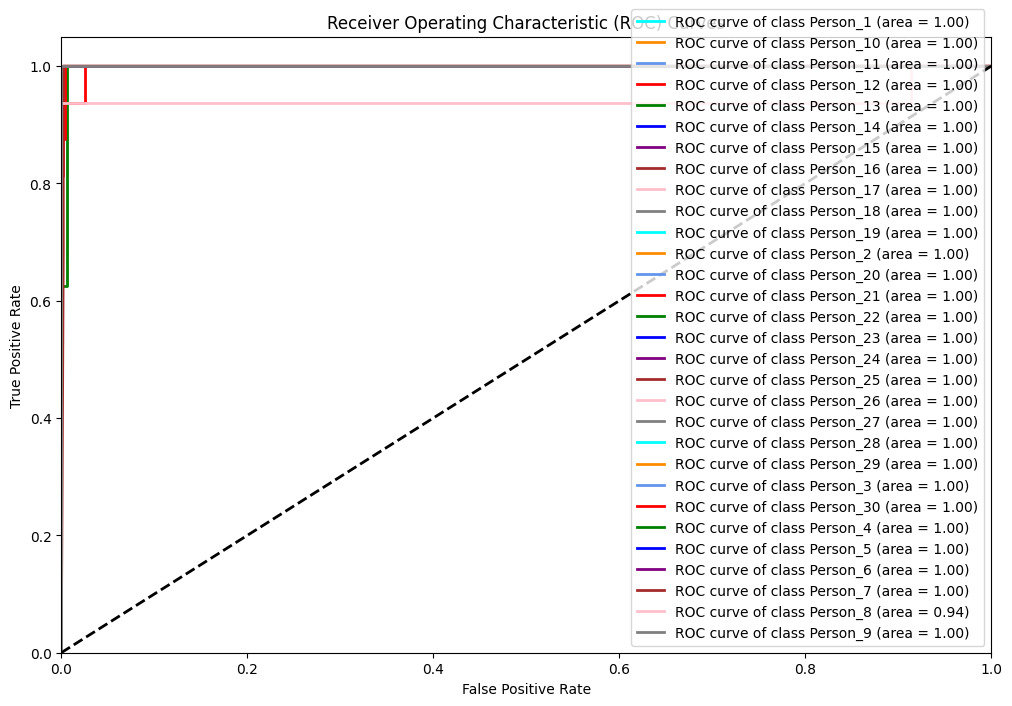

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute accuracy and precision for each class
from sklearn.metrics import accuracy_score, precision_score
from itertools import cycle
accuracy = accuracy_score(true_classes, predicted_classes)


# Print accuracy and precision
print(f'Accuracy: {accuracy}')




Accuracy: 0.9354166666666667


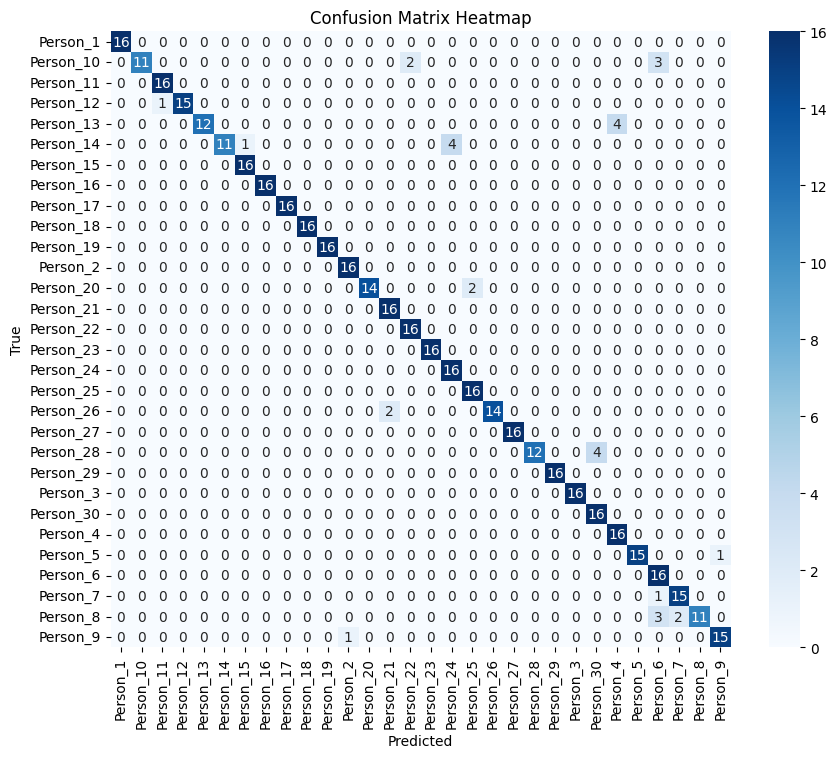

In [ ]:
import seaborn as sns
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()